In [1]:
!python --version

Python 3.8.0


In [2]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [5]:

DEVICE = "/gpu:0"  

In [6]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

ROOT_DIR = "C:/Users/anush/dl_project"
ROOT_DIR = os.getcwd()

sys.path.append(ROOT_DIR)  


COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


In [7]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    NAME = "object"


    GPU_COUNT = 1
    
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 1 + 2  # Background + Wound + Ruler

    
    STEPS_PER_EPOCH = 1

    DETECTION_MIN_CONFIDENCE = 0.9

In [8]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()


model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)
 
model_path = "C:\\Users\\anush\\dl_project\\logs\\object20240703T2002\\mask_rcnn_object_0250.h5"


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use fn_output_signature instead
Loading weights from  C:\Users\anush\dl_project\logs\object20240703T2002\mask_rcnn_object_0250.h5
Re-starting from epoch 250


In [9]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.add_class("object", 1, "wound")
        self.add_class("object", 2, "ruler")


     
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        if subset == "train":
            annotations1 = json.load(open('C:/Users/anush/dl_project/dataset/train/train_json.json'))
        elif subset == "val":
            annotations1 = json.load(open('C:/Users/anush/dl_project/dataset/val/val_json.json'))

       
        print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"wound": 1,"ruler": 2}

            num_ids = [name_dict[a] for a in objects]
     

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  
                image_id=a['filename'], 
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("C:/Users/anush/dl_project/dataset", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("C:/Users/anush/dl_project/dataset", "val")
dataset_val.prepare()

{'20240625_114849.jpg2542075': {'filename': '20240625_114849.jpg', 'size': 2542075, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1345, 1621, 1830, 2045, 2193, 2242, 2328, 2340, 2371, 2371, 2340, 2285, 2193, 2094, 1965, 1326, 1339], 'all_points_y': [867, 817, 830, 922, 1057, 1143, 1235, 1303, 1438, 1598, 1733, 1893, 2040, 2126, 2224, 873, 873]}, 'region_attributes': {'names': 'wound'}}], 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}, '20240625_114902.jpg2663617': {'filename': '20240625_114902.jpg', 'size': 2663617, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1100, 1063, 1155, 1315, 1413, 1530, 1610, 1677, 1665, 1647, 1585, 1518, 1469, 1462, 1505, 1591, 1677, 1684, 1634, 1561, 1604, 1696, 1641, 1518, 1364, 1266, 1192, 965, 836, 737, 651, 627, 621, 707, 768, 854, 971, 1075, 1118, 1118, 1118, 1112], 'all_points_y': [1585, 1419, 1235, 1143, 1149, 1174, 1235, 1327, 1426, 1512, 1616, 1714, 1819, 1905, 1966, 1960,

Processing 1 images
image                    shape: (3060, 4080, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 4080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Area of the ruler: 1680691 pixels
Area of mask 1: 1147321 pixels, 34.13 cm², Score: 0.9538297057151794


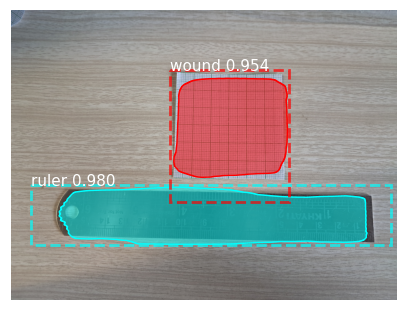

Processing 1 images
image                    shape: (3060, 4080, 3)       min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 4080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Area of the ruler: 1896924 pixels
Area of mask 1: 468293 pixels, 12.34 cm², Score: 0.9647939205169678


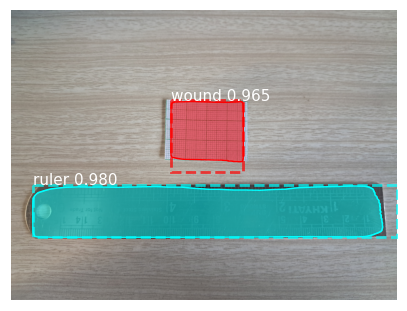

Processing 1 images
image                    shape: (3060, 4080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 4080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Area of the ruler: 1649999 pixels
Area of mask 0: 631944 pixels, 19.15 cm², Score: 0.9761315584182739


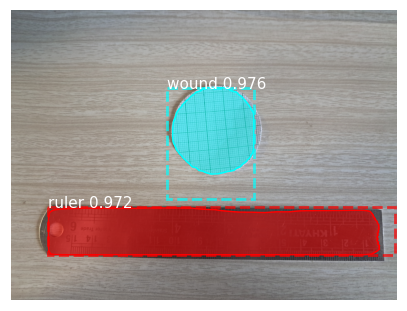

In [11]:
import os
import skimage
import skimage.io
import numpy as np

ref_area_cm2 = 50  # The area of the ruler in cm²

real_test_dir = 'C:/Users/anush/dl_project/test_images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

def calculate_area(mask):
    return np.sum(mask)

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    
    
    high_score_indices = [i for i, score in enumerate(r['scores']) if score > 0.83]
    filtered_rois = r['rois'][high_score_indices]
    filtered_masks = r['masks'][:, :, high_score_indices]
    filtered_class_ids = r['class_ids'][high_score_indices]
    filtered_scores = r['scores'][high_score_indices]

    
    ruler_index = None
    for i, class_id in enumerate(filtered_class_ids):
        if dataset_val.class_names[class_id] == 'ruler':
            ruler_index = i
            break

    if ruler_index is not None:
        
        ruler_mask = filtered_masks[:, :, ruler_index]
        ref_area_pixels = calculate_area(ruler_mask)
        print(f"Area of the ruler: {ref_area_pixels} pixels")

        
        conversion_factor = ref_area_cm2 / ref_area_pixels

        for i in range(filtered_masks.shape[-1]):
            if i != ruler_index: 
                mask = filtered_masks[:, :, i]
                area_pixels = calculate_area(mask)
                area_cm2 = area_pixels * conversion_factor
                print(f"Area of mask {i}: {area_pixels} pixels, {area_cm2:.2f} cm², Score: {filtered_scores[i]}")
    else:
        print("Ruler not found in the image.")

    visualize.display_instances(img, filtered_rois, filtered_masks, filtered_class_ids, 
                                dataset_val.class_names, filtered_scores, figsize=(5, 5))
